# 0) Setup — imports, paths, load a small stack

We’ll load the demo TIFF (`data/shorts/MoS1b_…001125.tiff`) using the new I/O API, and
grab a single representative frame for visualization. Helper funcs: percentile-based display and a simple “before/after” plot.


In [1]:
# --- setup ---
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from hybrid.io.readers import read_tiff_stack
from hybrid.masks import (
    # shapes
    tukey2d, cosine_disk, hard_disk, soft_disk, hard_ellipse, soft_ellipse, hard_rect, soft_rect,
    # crop
    crop_sides, crop_to_bbox, crop_center, crop_square,
    # build
    build_soft_disk_mask, apply_mask_to_array, build_and_apply_fov,
)

# Paths
DATA_DIR = Path("data/shorts")
BASENAME = "MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.tiff"
SRC = (DATA_DIR / BASENAME)

# Load (T,Y,X) float32; no normalization so we see raw-like intensities
stack = read_tiff_stack(SRC.as_posix(), method="auto", normalize_mode="none", dtype="float32", verbose=False)
T, H, W = stack.shape
frame = stack[T//2]  # middle frame for demo

def vlim(img, p=(1,99)):
    lo, hi = np.percentile(img[np.isfinite(img)], p)
    if hi <= lo: hi = lo + 1.0
    return float(lo), float(hi)

def show_pair(a, b, titles=("Before","After"), p=(1,99), mask=None):
    vm_a = vlim(a, p if mask is None else p)
    vm_b = vlim(b, p if mask is None else p)
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].imshow(a, cmap="gray", vmin=vm_a[0], vmax=vm_a[1]); axs[0].set_title(titles[0]); axs[0].set_axis_off()
    axs[1].imshow(b, cmap="gray", vmin=vm_b[0], vmax=vm_b[1]); axs[1].set_title(titles[1]); axs[1].set_axis_off()
    plt.tight_layout(); plt.show()

print("stack:", stack.shape, stack.dtype)


stack: (300, 800, 768) float32


# 1) Hard/soft circular disk masks

We’ll build a **hard** (binary) and a **soft** (cosine-taper) circular mask centered at the image center and apply them to the demo frame. The soft mask uses a small edge width so you can see the smooth roll-off.


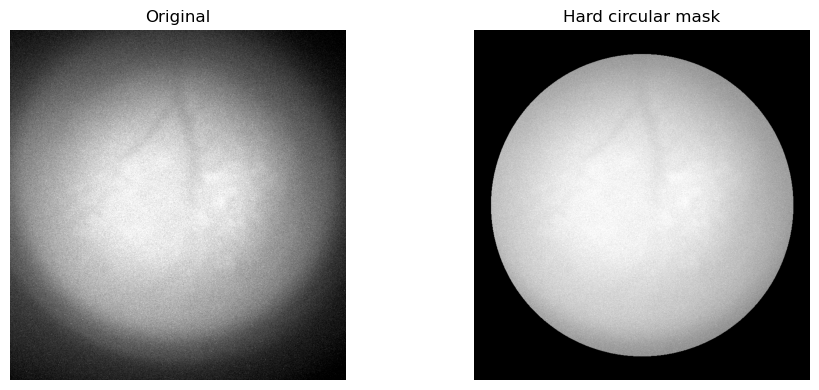

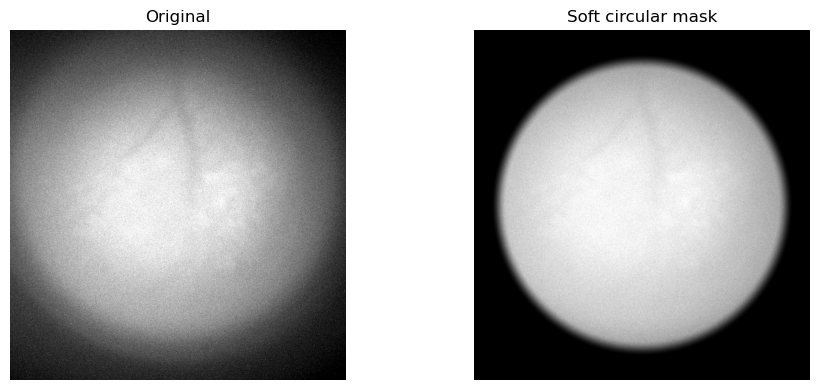

In [2]:
# --- 1) disks: hard vs soft
H, W = frame.shape
cy, cx = H/2, W/2
r = min(H, W) * 0.45

m_hard = hard_disk(H, W, cy, cx, r)
m_soft = soft_disk(H, W, cy, cx, r, edge=36)

show_pair(frame, frame * m_hard, titles=("Original", "Hard circular mask"), mask=m_hard)
show_pair(frame, frame * m_soft, titles=("Original", "Soft circular mask"), mask=m_soft)


# 2) Axis-aligned rectangles (hard/soft)

Rectangles in `hybrid.masks.shapes` are defined by **center + half-sizes**.
Below we start from a bounding box `(y0, x0, y1, x1)`, convert to the required
parameters, and apply both hard and soft variants.


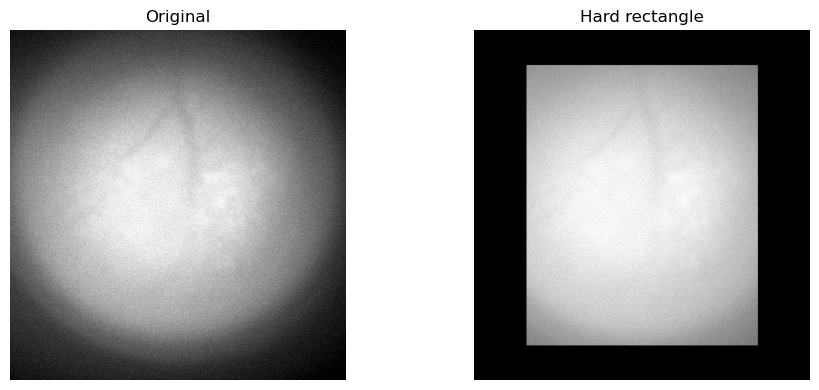

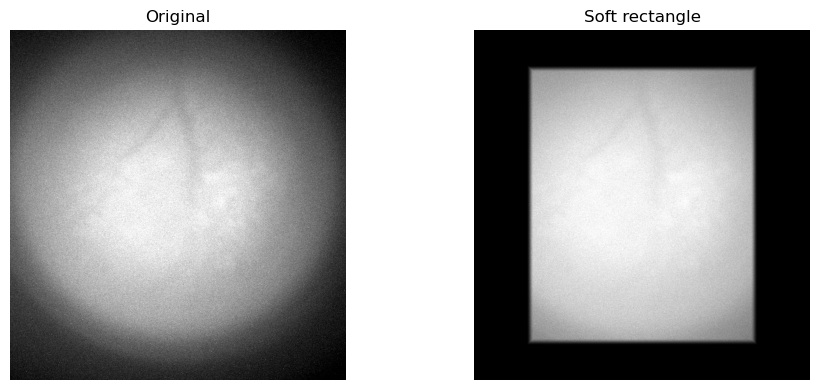

In [3]:
# --- 2) rectangles
y0, x0, y1, x1 = 80, 120, H - 80, W - 120
cy = 0.5 * (y0 + y1)
cx = 0.5 * (x0 + x1)
hy = 0.5 * (y1 - y0)
hx = 0.5 * (x1 - x0)

m_rect_h = hard_rect(H, W, cy, cx, hy, hx)
m_rect_s = soft_rect(H, W, cy, cx, hy, hx, edge_y=16)

show_pair(frame, frame * m_rect_h, titles=("Original", "Hard rectangle"), mask=m_rect_h)
show_pair(frame, frame * m_rect_s, titles=("Original", "Soft rectangle"), mask=m_rect_s)


# 3) Ellipses (hard/soft)

Ellipses are defined by center `(cy, cx)` and radii `(ry, rx)`. The soft version
uses a cosine taper with edge width specified in **pixels** (interpreted against the minor radius).


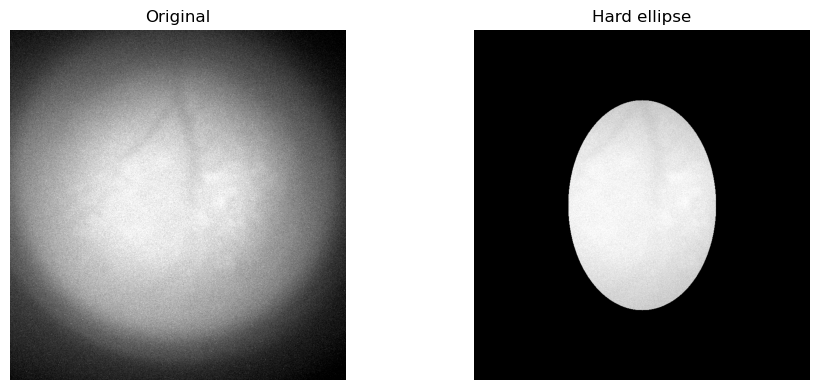

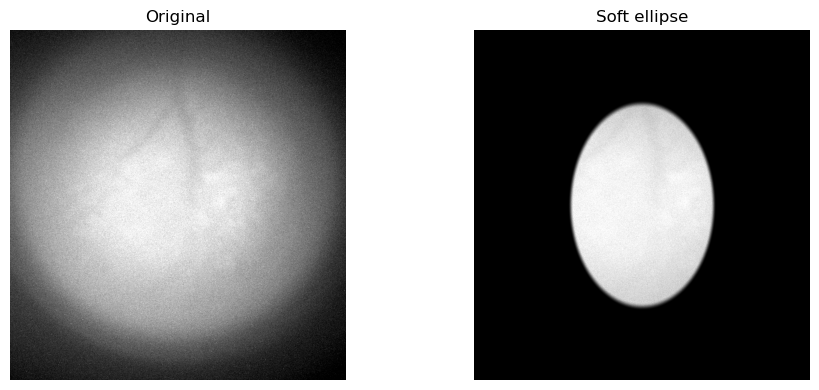

In [4]:
# --- 3) ellipses
ry, rx = H * 0.30, W * 0.22
m_ell_h = hard_ellipse(H, W, cy, cx, ry, rx)
m_ell_s = soft_ellipse(H, W, cy, cx, ry, rx, edge_px=12)

show_pair(frame, frame * m_ell_h, titles=("Original", "Hard ellipse"), mask=m_ell_h)
show_pair(frame, frame * m_ell_s, titles=("Original", "Soft ellipse"), mask=m_ell_s)


# 4) Rectangular apodization (Tukey 2D)

`tukey2d(h, w, alpha)` builds a rectangular window in `[0,1]`.  
Here we apply it across the whole frame to illustrate the cosine roll-off at the borders.


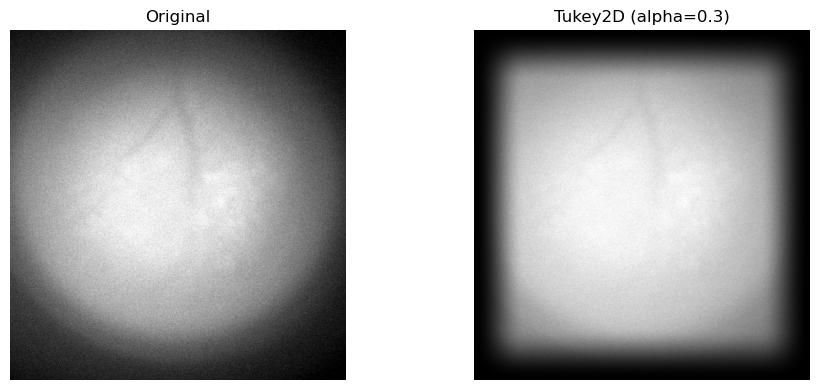

In [5]:
# --- 4) Tukey window over full frame
win = tukey2d(H, W, alpha=0.3)
show_pair(frame, frame * win, titles=("Original", "Tukey2D (alpha=0.3)"))


# 5) Cropping utilities

Demonstrate four crop helpers:
- `crop_sides(img, top, bottom, left, right)`
- `crop_to_bbox(img, y0, x0, y1, x1)`
- `crop_center(img, height, width)`
- `crop_square(img, side, center=None)`

Each example shows **before/after**.


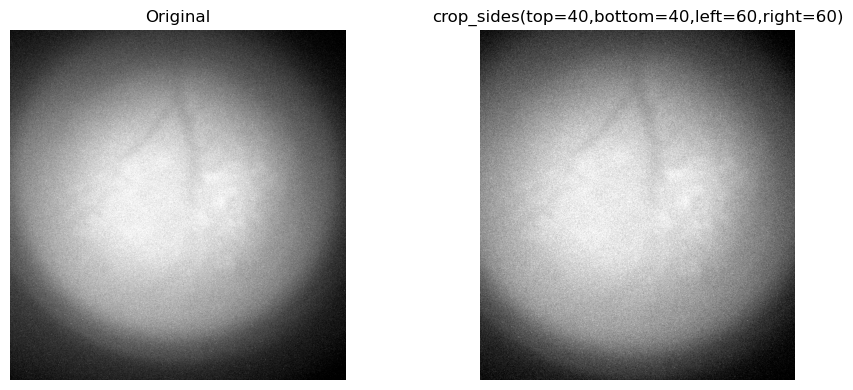

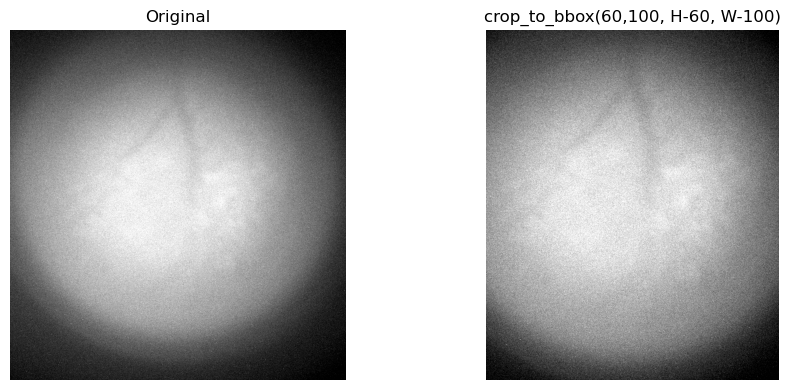

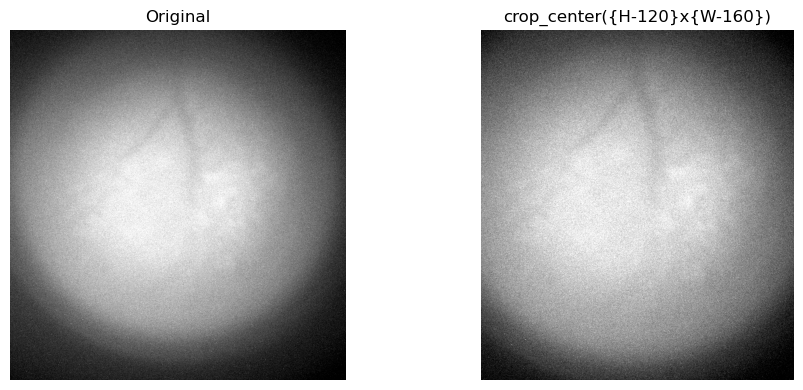

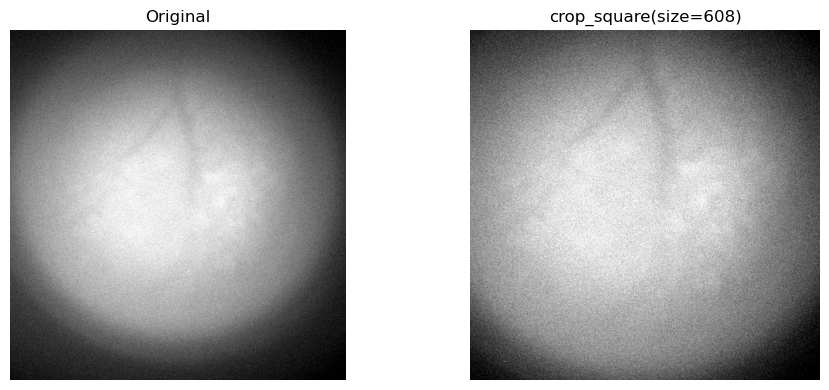

In [6]:
# --- 5) crops
from hybrid.masks import crop_sides, crop_to_bbox, crop_center, crop_square

# 5.1 sides
img_sides = crop_sides(frame, top=40, bottom=40, left=60, right=60)
show_pair(frame, img_sides, titles=("Original", "crop_sides(top=40,bottom=40,left=60,right=60)"))

# 5.2 bbox
bbox_y0, bbox_x0, bbox_y1, bbox_x1 = 60, 100, H-60, W-100
img_bbox = crop_to_bbox(frame, bbox_y0, bbox_x0, bbox_y1, bbox_x1)
show_pair(frame, img_bbox, titles=("Original", "crop_to_bbox(60,100, H-60, W-100)"))

# 5.3 center HxW
img_center = crop_center(frame, height=H-120, width=W-160)
show_pair(frame, img_center, titles=("Original", "crop_center({H-120}x{W-160})"))

# 5.4 centered square
side = min(H, W) - 160
img_square = crop_square(frame, size=side)   # <-- size, not side
show_pair(frame, img_square, titles=("Original", f"crop_square(size={side})"))


# 6) High-level builder: soft circular FOV mask

`build_soft_disk_mask(...)` can **autoguess** center/radius and return a smooth FOV mask.  
We’ll try both the autoguess mode and a manual override. Then we’ll use
`apply_mask_to_array(...)` to apply it to the whole stack.


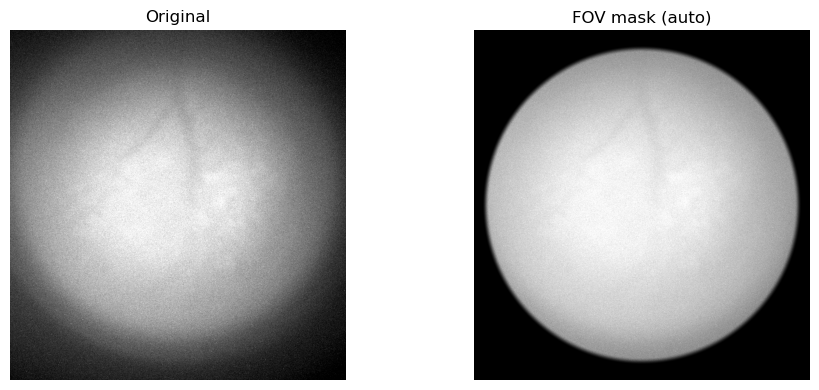

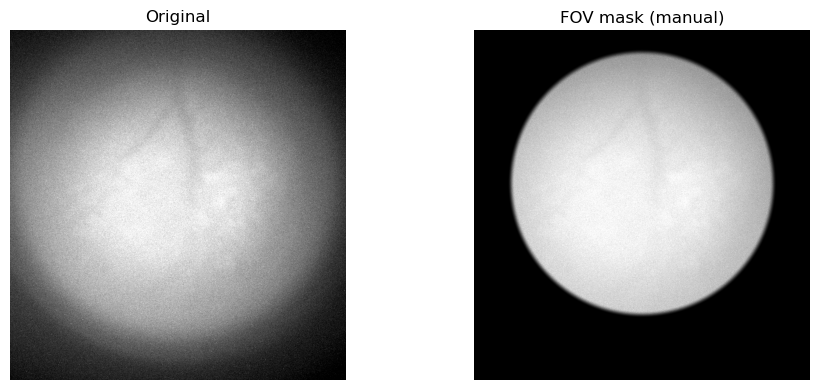

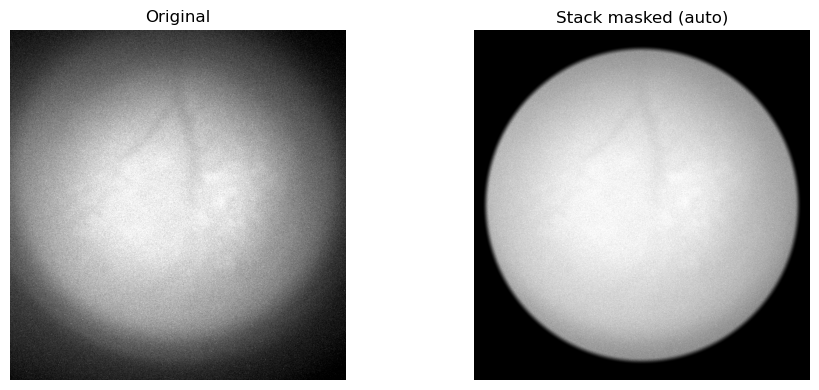

In [14]:
# --- 6) FOV mask — auto and manual ------------------------------------------
from hybrid.masks import build_soft_disk_mask, apply_mask_to_array

H, W = frame.shape

# 6.1 "Auto" = geometrical center + radius by r_frac
m_auto, (cy_auto, cx_auto), r_auto = build_soft_disk_mask(
    H, W,
    r_frac=0.95,
    edge_px=16,
)
show_pair(frame, frame * m_auto, titles=("Original", "FOV mask (auto)"), mask=m_auto)

# 6.2 Manual center & radius
r_manual = min(H, W) * 0.4
cy, cx = H/2-50, W/2
m_manual, _, _ = build_soft_disk_mask(
    H, W,
    cy=cy, cx=cx,
    r=r_manual,
    edge_px=16,
)
show_pair(frame, frame * m_manual, titles=("Original", "FOV mask (manual)"), mask=m_manual)

# 6.3 apply the chosen mask to the whole stack (T,Y,X) × (Y,X)
stack_masked = apply_mask_to_array(stack, m_auto)  
show_pair(frame, stack_masked[T//2], titles=("Original", "Stack masked (auto)"), mask=m_auto)



### 7) One-shot pipeline: **build _and_ apply** FOV

`build_and_apply_fov(arr, ...)` builds a soft circular FOV mask (auto or manual) **and** applies it to the array in one call.

It returns a **dict** with:
- `result["stack"]` – masked array (same shape as input),
- `result["mask_soft"]` – the mask `(H, W)`,
- `result["center"]`, `result["radius"]`,
- `result["crop_box"]`, `result["shape_in"]`, `result["shape_out"]`, `result["params"]`.

Below:
1) Auto center/radius (no crop).  
2) Same but with a demo crop (bbox) before masking.


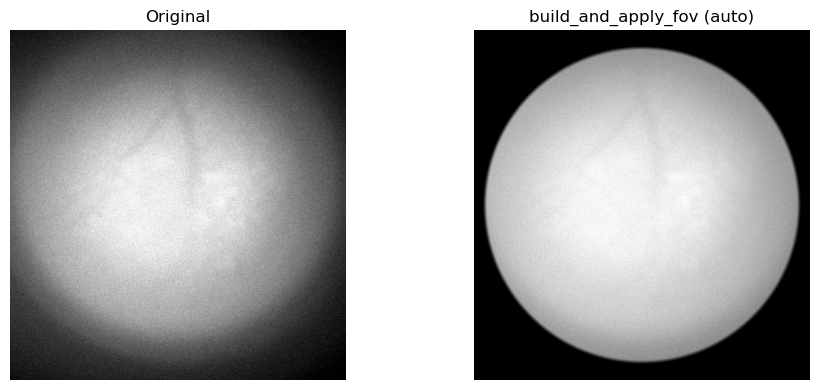

Auto result:
  center: (399.5, 383.5)
  radius: 364.80
  shape_in -> shape_out: (300, 800, 768) -> (300, 800, 768)
  crop_box: None
  params: {'r_frac': 0.95, 'edge_px': 12.0, 'out_dtype': 'float32'}


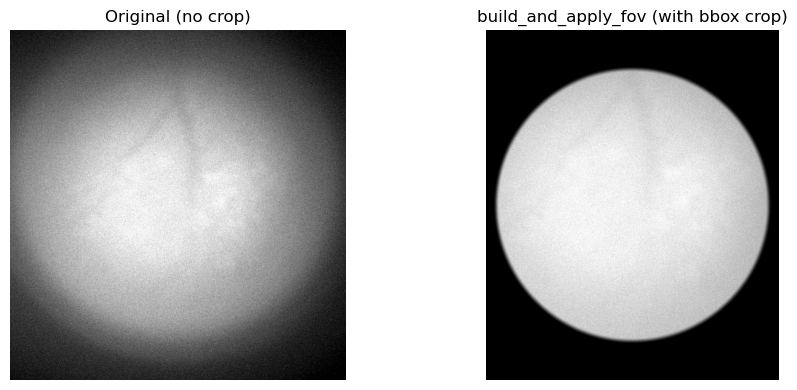


Crop+mask result:
  center: (339.5, 283.5)
  radius: 269.80
  shape_in -> shape_out: (300, 800, 768) -> (300, 680, 568)
  crop_box: (60, 100, 740, 668)
  params: {'r_frac': 0.95, 'edge_px': 12.0, 'out_dtype': 'float32'}


In [8]:
# --- 7) build + apply in one go -------------------------------------------
from hybrid.masks import build_and_apply_fov

# 7.1 Auto center/radius (no crop)
res_auto = build_and_apply_fov(
    stack,
    edge_px=12,             # soft edge, in pixels
    r_frac=0.95,            # radius fallback if 'radius' not given
    out_dtype="float32",
)
stack_masked2 = res_auto["stack"]
m2            = res_auto["mask_soft"]

# visualize the same middle frame
show_pair(frame, stack_masked2[T//2], titles=("Original", "build_and_apply_fov (auto)"), mask=m2)

print("Auto result:")
print("  center:", res_auto["center"])
print("  radius:", f"{res_auto['radius']:.2f}")
print("  shape_in -> shape_out:", res_auto["shape_in"], "->", res_auto["shape_out"])
print("  crop_box:", res_auto["crop_box"])
print("  params:", res_auto["params"])

# 7.2 With a demo crop (bbox) before masking
res_crop = build_and_apply_fov(
    stack,
    crop={"mode": "bbox", "y0": 60, "x0": 100, "y1": H-60, "x1": W-100},  # example crop
    edge_px=12,
    out_dtype="float32",
)
stack_masked_crop = res_crop["stack"]
m2_crop            = res_crop["mask_soft"]

# visualize cropped+masked middle frame
show_pair(
    stack[T//2], stack_masked_crop[T//2],
    titles=("Original (no crop)", "build_and_apply_fov (with bbox crop)"),
    mask=m2_crop
)

print("\nCrop+mask result:")
print("  center:", res_crop["center"])
print("  radius:", f"{res_crop['radius']:.2f}")
print("  shape_in -> shape_out:", res_crop["shape_in"], "->", res_crop["shape_out"])
print("  crop_box:", res_crop["crop_box"])
print("  params:", res_crop["params"])


### 8) Crop first, then build a soft circular FOV on the **cropped** view

`build_soft_disk_mask(H, W, ...)` expects sizes, not an array.  
Grab `H, W = cropped.shape` and call it; then visualize.


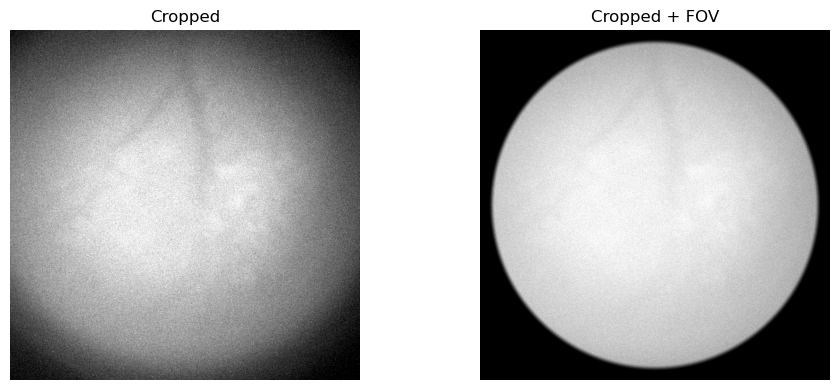

cropped shape: (648, 648), center=(323.5,323.5), r=307.8


In [9]:
# --- 8) crop then mask
cropped = crop_square(frame, size=min(H, W) - 120)

# build soft circular FOV on the cropped frame
Hc, Wc = cropped.shape
m_cropped, (cy_c, cx_c), r_c = build_soft_disk_mask(Hc, Wc, edge_px=12)

show_pair(
    cropped, cropped * m_cropped,
    titles=("Cropped", "Cropped + FOV"),
    mask=m_cropped
)

print(f"cropped shape: {cropped.shape}, center=({cy_c:.1f},{cx_c:.1f}), r={r_c:.1f}")


# 9) Tiny assertions (optional)

A couple of quick checks that shapes/crops keep expected dtypes and ranges.


In [10]:
# --- 9) quick checks
assert m_hard.dtype == np.uint8 and set(np.unique(m_hard)).issubset({0,1})
assert m_soft.dtype == np.float32 and 0.0 <= float(m_soft.min()) <= float(m_soft.max()) <= 1.0
assert win.shape == frame.shape and win.dtype == np.float32
assert img_bbox.shape == (bbox_y1 - bbox_y0, bbox_x1 - bbox_x0)
print("Masks & crops basic checks passed ✅")


Masks & crops basic checks passed ✅


### Extra: crop by sides → center soft disk mask (frame + whole stack)

We’ll:
1) crop the image by removing a fixed number of pixels from each side using `crop_sides(...)`,  
2) build a **soft circular mask** centered on the **cropped** view with `soft_disk(...)`,  
3) visualize the masked **frame**, and (optionally) apply the same mask to the **whole stack**.

Parameters to play with:
- `top/bottom/left/right` – how many pixels to trim on each side
- `edge_px` – cosine roll-off width of the soft disk (pixels)
- `r_frac` – fraction of the inscribed radius (e.g., 0.95 ⇒ radius = 0.95 * min(Hc, Wc)/2)


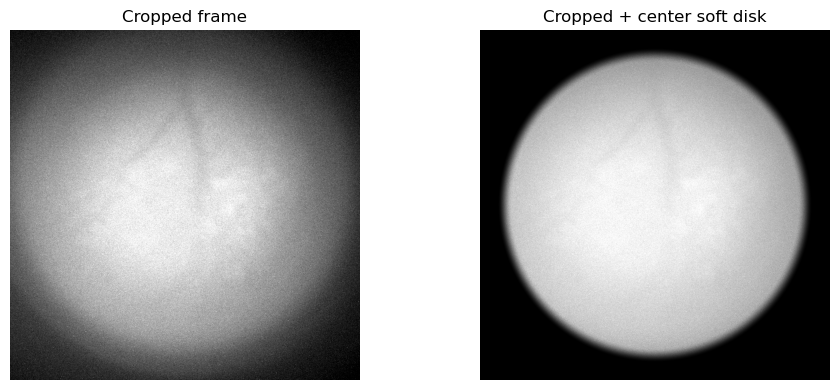

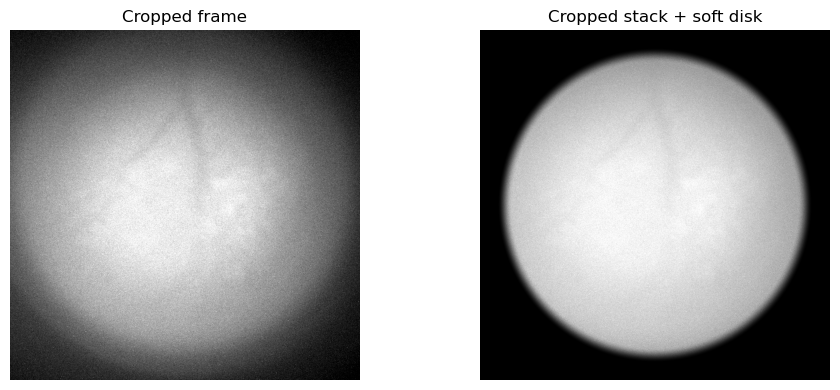

Cropped shape: 768x768, center=(383.5,383.5), radius=345.6, edge=32px


In [11]:
# --- crop by sides, then center soft disk mask ---

from hybrid.masks import crop_sides, soft_disk, apply_mask_to_array

# 1) choose crop + mask params
top, bottom, left, right = 0, 32, 0, 0
edge_px = 32
r_frac  = 0.9  # radius as a fraction of the inscribed radius

# 2) crop the reference frame and compute a center-soft disk on the cropped view
frame_c = crop_sides(frame, top=top, bottom=bottom, left=left, right=right)
Hc, Wc  = frame_c.shape
cy, cx  = (Hc - 1) / 2.0, (Wc - 1) / 2.0
r       = r_frac * min(Hc, Wc) / 2.0

m_c = soft_disk(Hc, Wc, cy, cx, r, edge=edge_px)

# visualize (before/after) for the single frame
show_pair(frame_c, frame_c * m_c,
          titles=("Cropped frame", "Cropped + center soft disk"), mask=m_c)

# 3) (optional) apply the same mask to the whole stack after the same crop
stack_c       = crop_sides(stack, top=top, bottom=bottom, left=left, right=right)
stack_masked  = apply_mask_to_array(stack_c, m_c)  # broadcasts mask over time

# show the same middle slice from the masked stack
T = stack_masked.shape[0]
show_pair(frame_c, stack_masked[T//2],
          titles=("Cropped frame", "Cropped stack + soft disk"), mask=m_c)

print(f"Cropped shape: {Hc}x{Wc}, center=({cy:.1f},{cx:.1f}), radius={r:.1f}, edge={edge_px}px")
